# Feature Engineering

## Objectives
- Engineer features for Classification, Regression and Cluster models

## Outputs

- Return enginered features

---

## Setting working Directory
The steps below allow to set heart_attack risk as the new working directory

- get current directory and print it


In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heart_attack_risk/jupyer_notebooks'

- set new working directory as parent of the previous current directory
- As a result heart_attack_risk is the new working directory  

In [2]:
os.chdir(os.path.dirname(current_dir))


---

## Load Cleaned Data

Train Set

In [3]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,70,M,ASY,140,335.0,1,Normal,157,Y,2.0,Flat,1
1,46,M,ASY,115,186.0,0,Normal,113,Y,1.5,Flat,1
2,65,F,NAP,160,360.0,0,LVH,151,N,0.8,Up,0


Test test

In [4]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,55,M,ASY,115,216.0,1,Normal,155,N,0.1,Flat,1
1,66,M,ASY,120,302.0,0,LVH,151,N,0.4,Flat,0
2,51,M,ASY,110,353.0,1,Normal,92,N,0.0,Flat,1


## Data Overview

Data overview after splitting datase into train and test


In [5]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Feature Engineering

- Tests feature engineering on both numerical and categorical variables
- Remove fetures which correlate to each other
- Checks which feature engineering works best
- Plot the results


In [5]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

### Categorical encoding

Create a copy of the training database including only categorical features

In [6]:
train_categorical = TrainSet.select_dtypes(include=['object', 'category'])
categorical_variables = train_categorical.columns.tolist()
train_categorical.head()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ASY,Normal,Y,Flat
1,M,ASY,Normal,Y,Flat
2,F,NAP,LVH,N,Up
3,M,ASY,Normal,Y,Flat
4,M,ASY,ST,Y,Flat


Apply categorical encoding to the new database

* Variable Analyzed: Sex
* Applied transformation: ['Sex_ordinal_encoder'] 



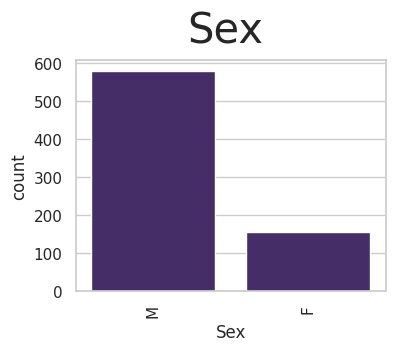

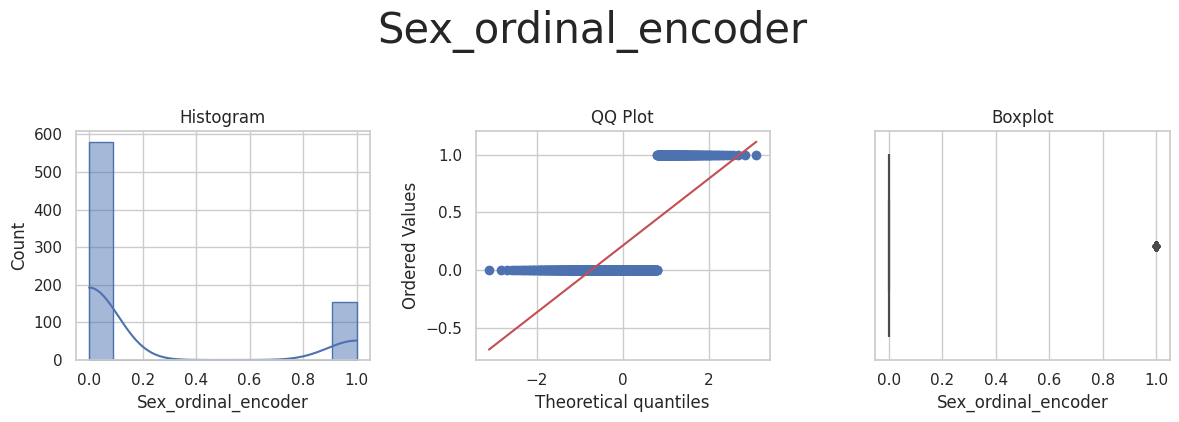



* Variable Analyzed: ChestPainType
* Applied transformation: ['ChestPainType_ordinal_encoder'] 



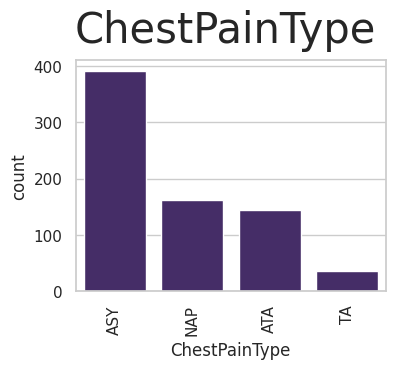

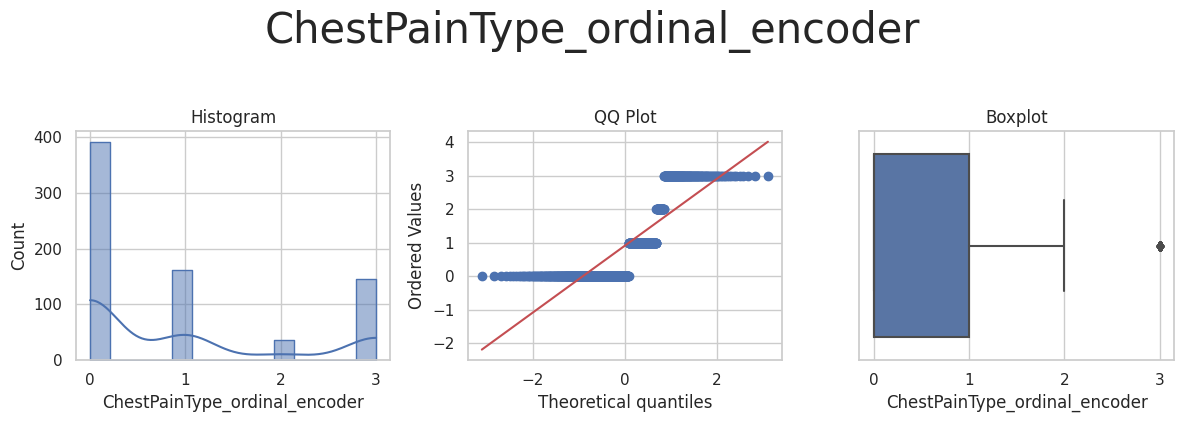



* Variable Analyzed: RestingECG
* Applied transformation: ['RestingECG_ordinal_encoder'] 



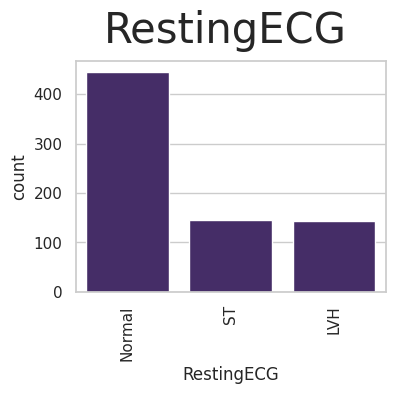

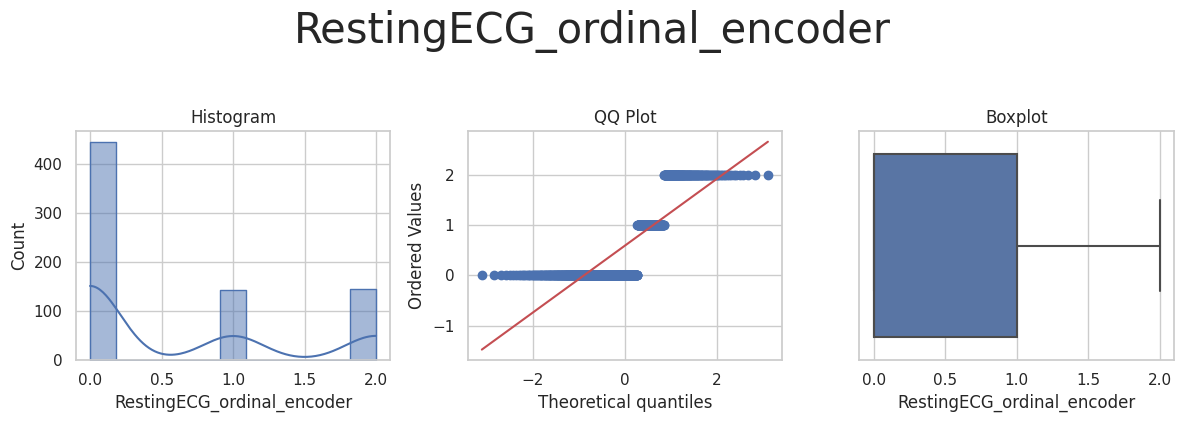



* Variable Analyzed: ExerciseAngina
* Applied transformation: ['ExerciseAngina_ordinal_encoder'] 



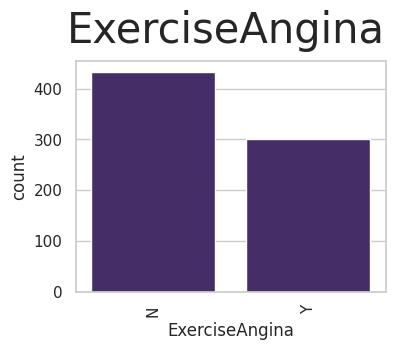

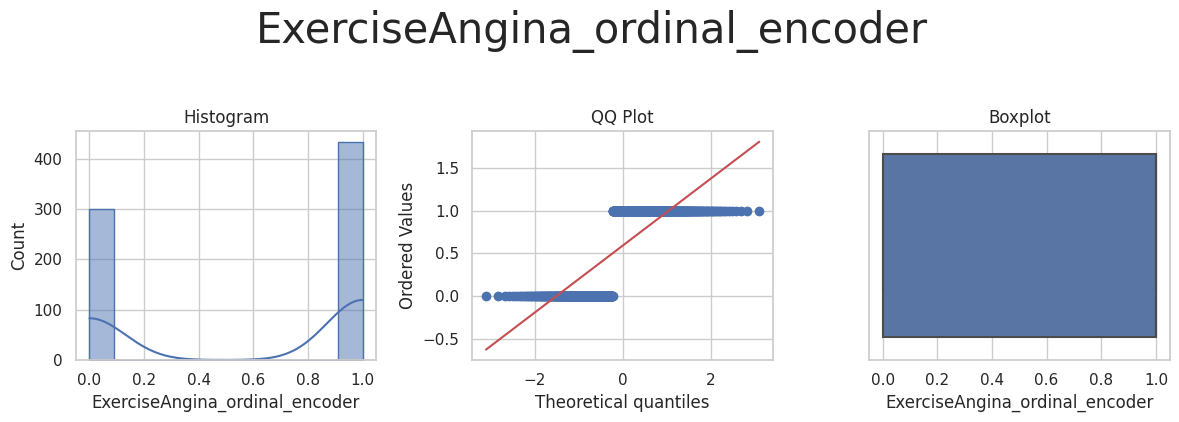



* Variable Analyzed: ST_Slope
* Applied transformation: ['ST_Slope_ordinal_encoder'] 



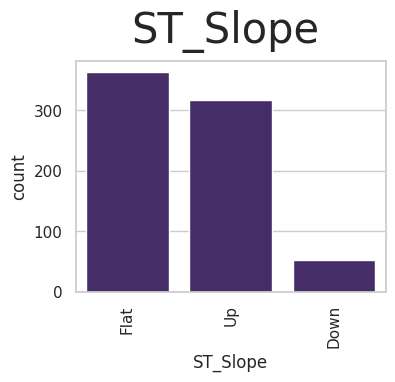

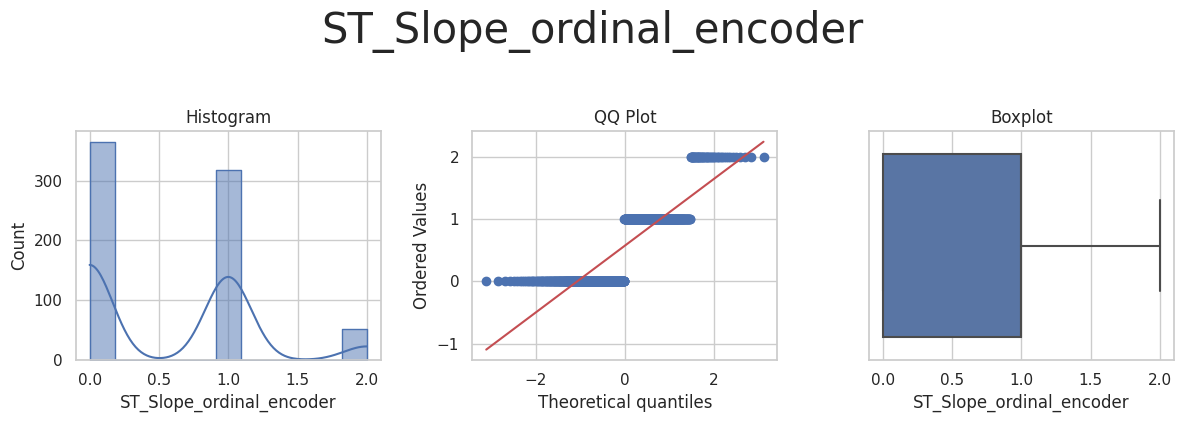

In [7]:
train_categorical = FeatureEngineeringAnalysis(df=train_categorical, analysis_type='ordinal_encoder')


- All categorical variable are successfully converted into numerical
- The QQ-plot shows that none of the categorical distributions is normal
- The Sex feature show unbalancing
- In Resting ECG the Normal category is unbalanced
- In ST slope the down category is unbalanced

Since all categorical features have been successfully transformed into numerical
I will now apply the same transformation to the Train and test dataset

In [8]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = categorical_variables )
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)
print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


### Numerical transformation

Create a copy of the training dataset including only numerical variables

In [9]:
train_numerical = TrainSet.select_dtypes(include=['int64', 'float64'])
train_numerical.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,70,0,0,140,335.0,1,0,157,0,2.0,0,1
1,46,0,0,115,186.0,0,0,113,0,1.5,0,1
2,65,1,1,160,360.0,0,1,151,1,0.8,1,0
3,66,0,0,140,139.0,0,0,94,0,1.0,0,1
4,59,0,0,140,274.0,0,2,117,0,1.0,0,1


FastingBS and HeartDisease are categorical variables already converted into numerical.

Therefore, I am dropping FastingBS and HeartDisease from the train_numerical dataframe and from the colums list

I will also drop the categorical variable transformed into numerical in the previous step

In [10]:
train_numerical = train_numerical.drop(categorical_variables + ['FastingBS', 'HeartDisease'], axis=1)
numerical_features =  train_numerical.columns.tolist()
train_numerical.head()


,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,70,140,335.0,157,2.0
1,46,115,186.0,113,1.5
2,65,160,360.0,151,0.8
3,66,140,139.0,94,1.0
4,59,140,274.0,117,1.0


In [11]:
numerical_features

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

Apply numerical transformation to the numerical dataframe

* Variable Analyzed: Age
* Applied transformation: ['Age_log_e', 'Age_log_10', 'Age_reciprocal', 'Age_power', 'Age_box_cox', 'Age_yeo_johnson'] 



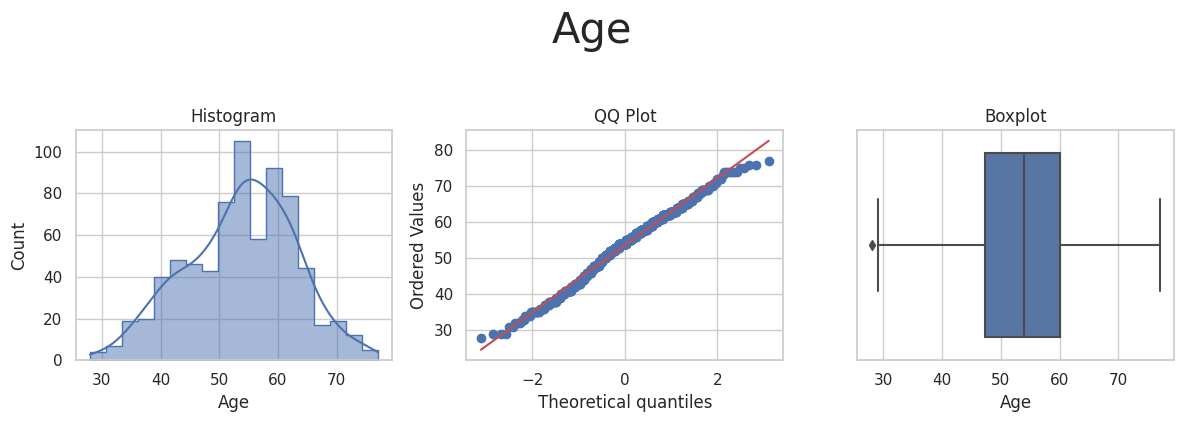

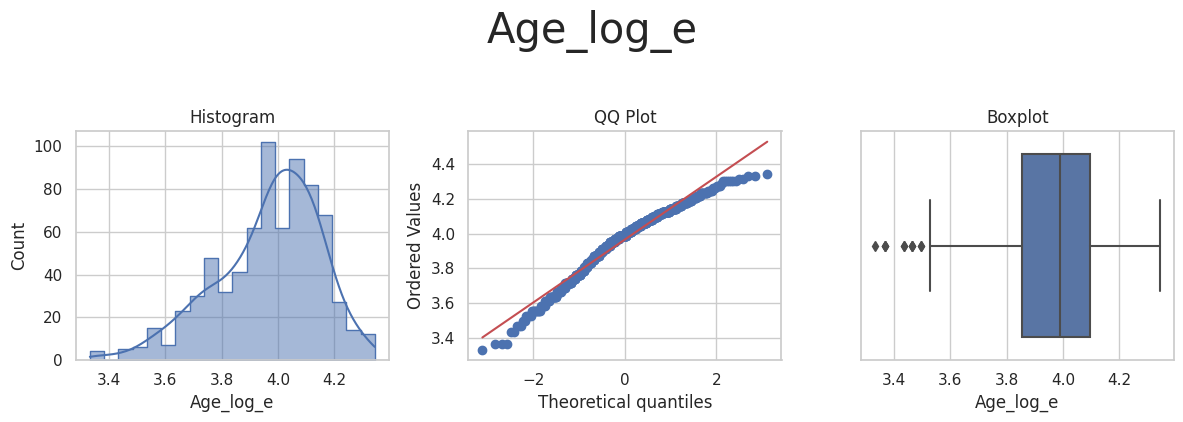

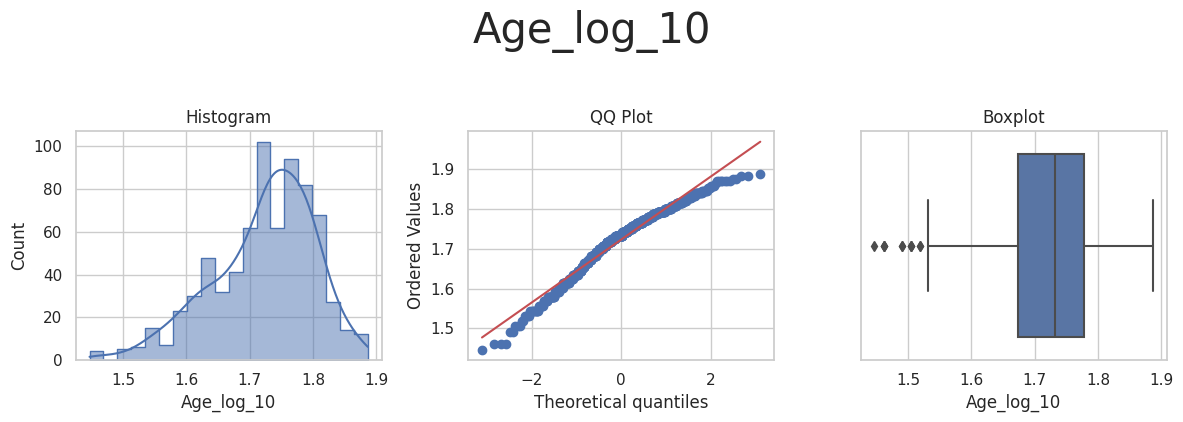

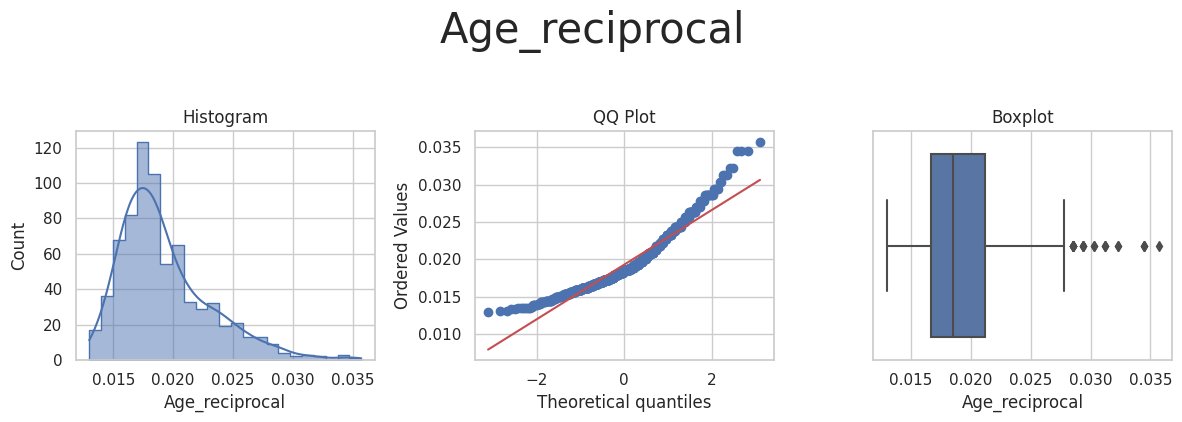

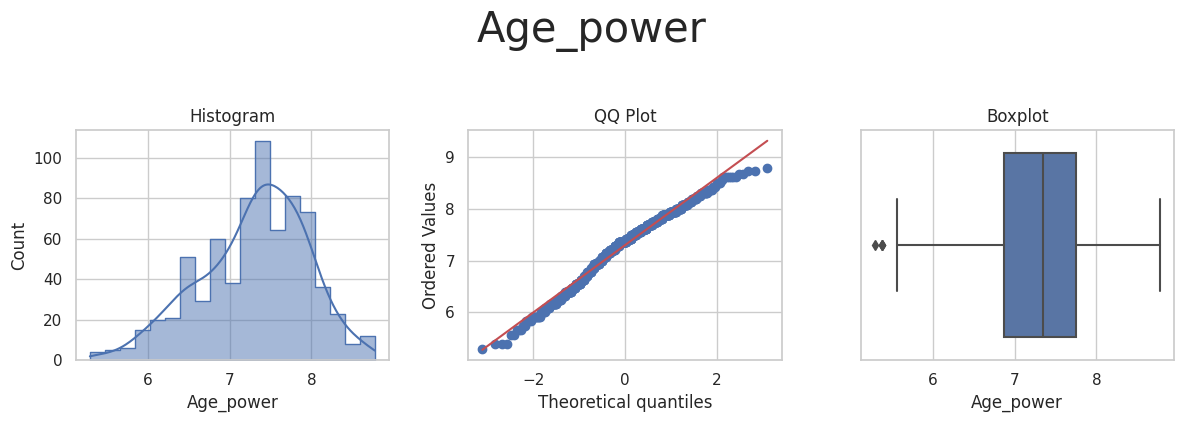

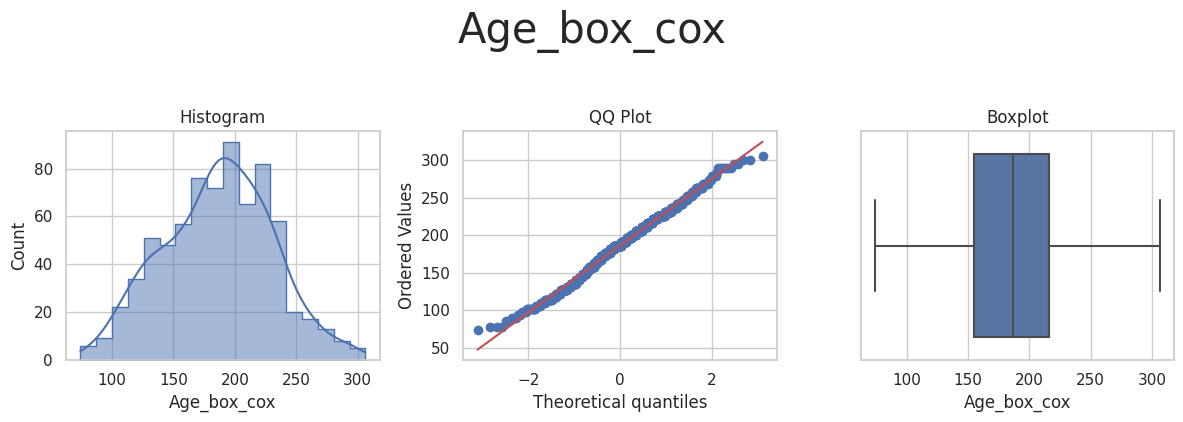

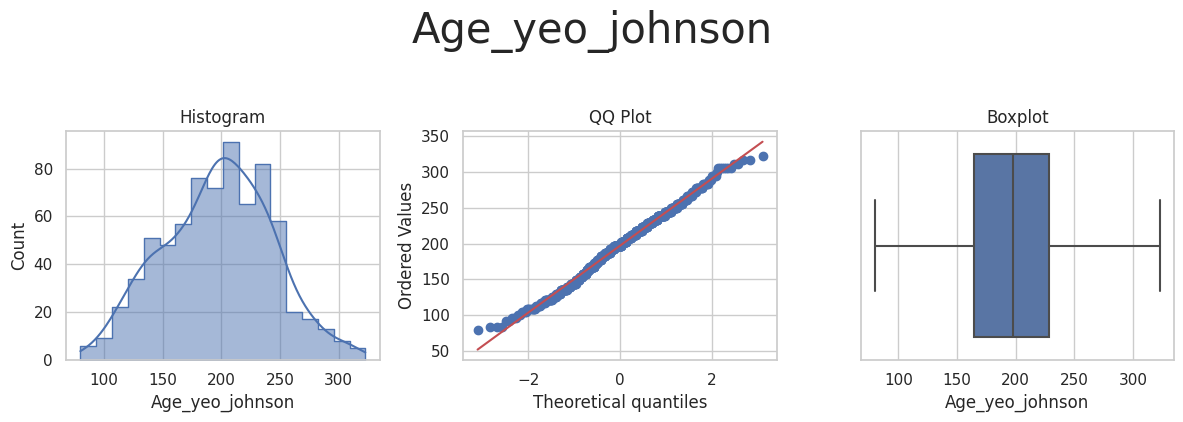



* Variable Analyzed: RestingBP
* Applied transformation: ['RestingBP_power', 'RestingBP_yeo_johnson'] 



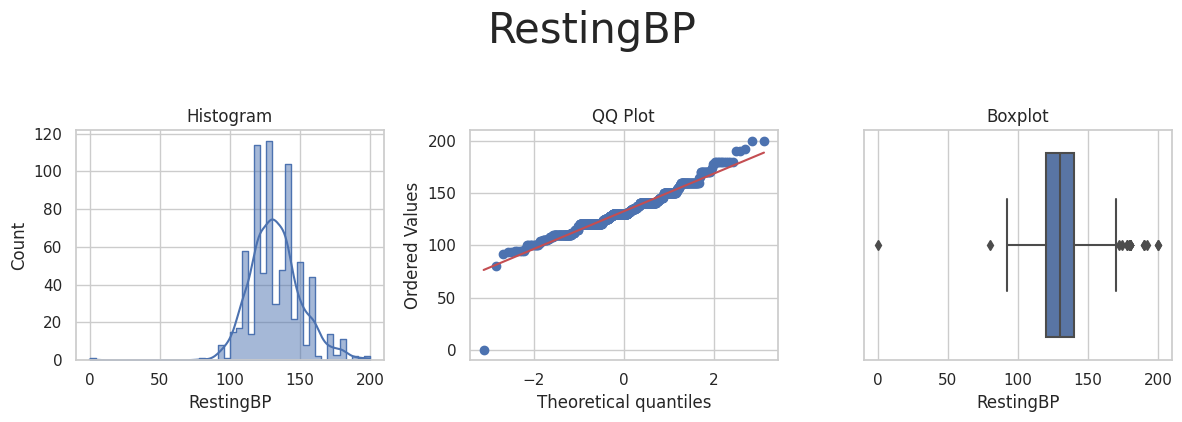

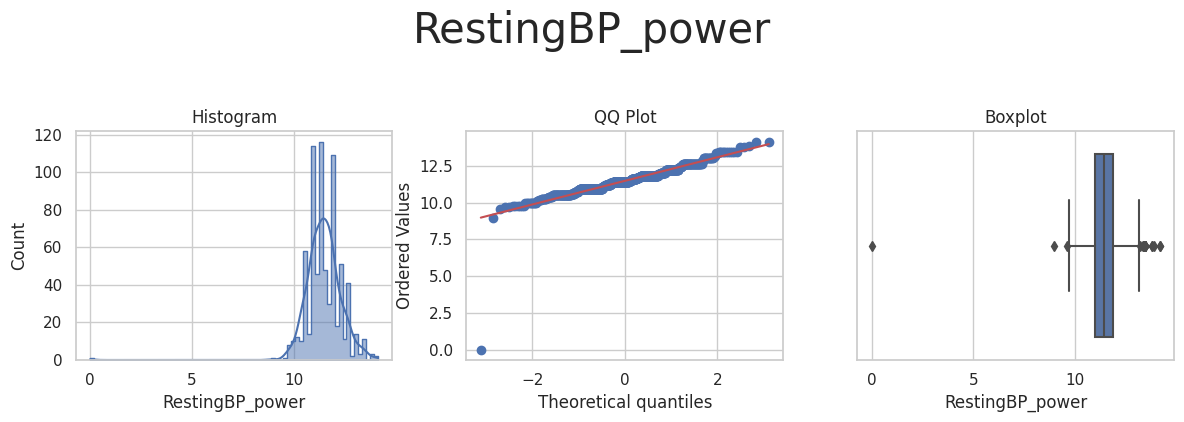

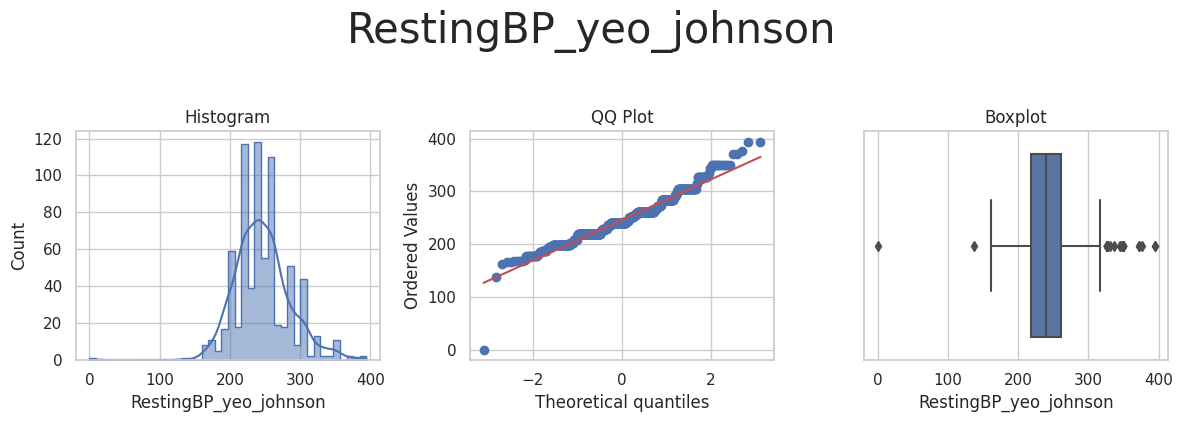



* Variable Analyzed: Cholesterol
* Applied transformation: ['Cholesterol_log_e', 'Cholesterol_log_10', 'Cholesterol_reciprocal', 'Cholesterol_power', 'Cholesterol_box_cox', 'Cholesterol_yeo_johnson'] 



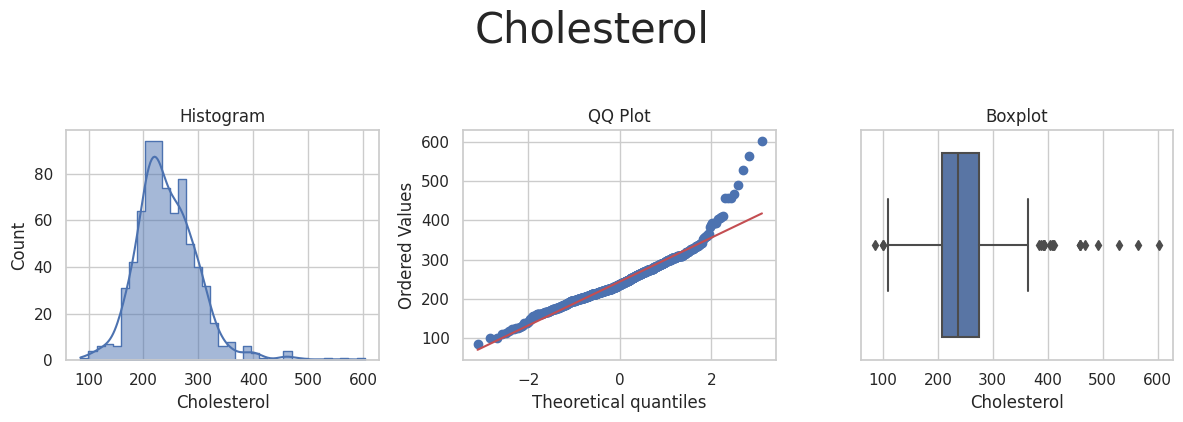

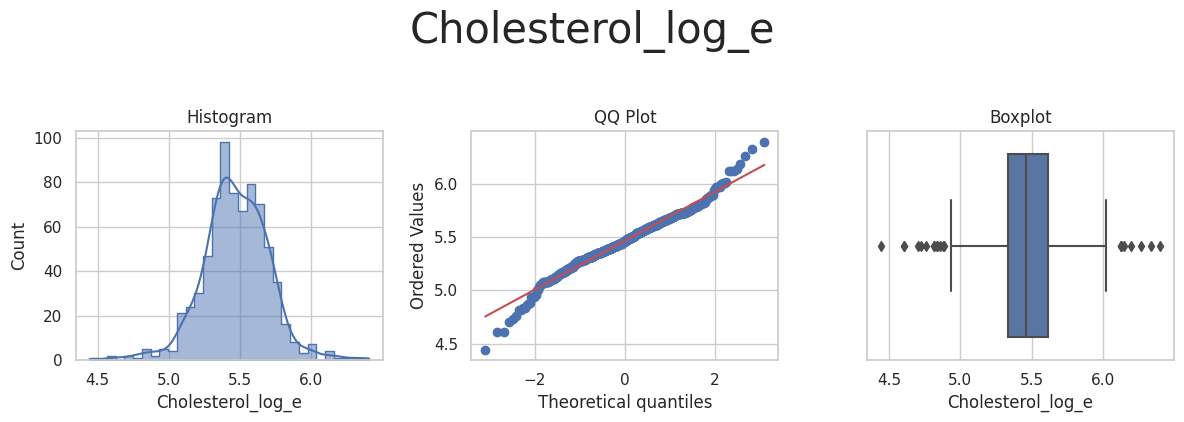

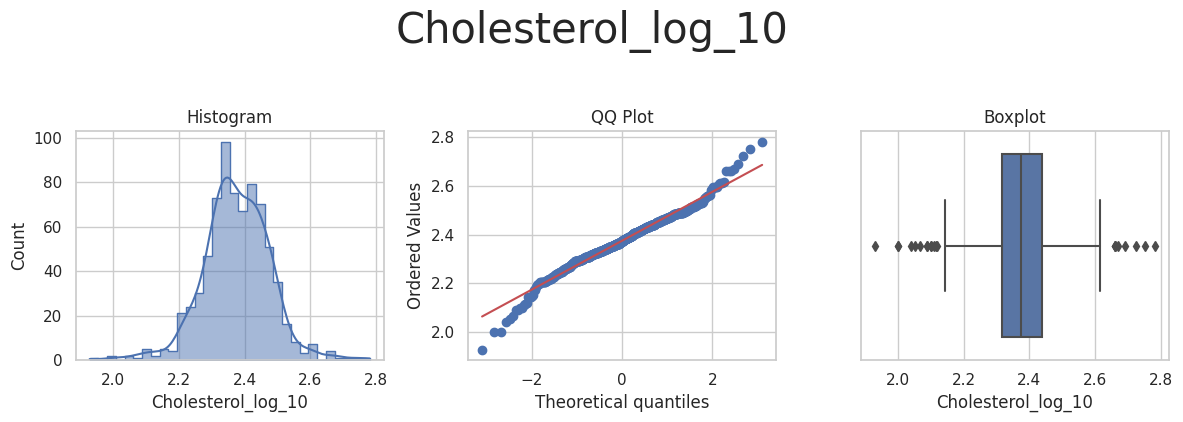

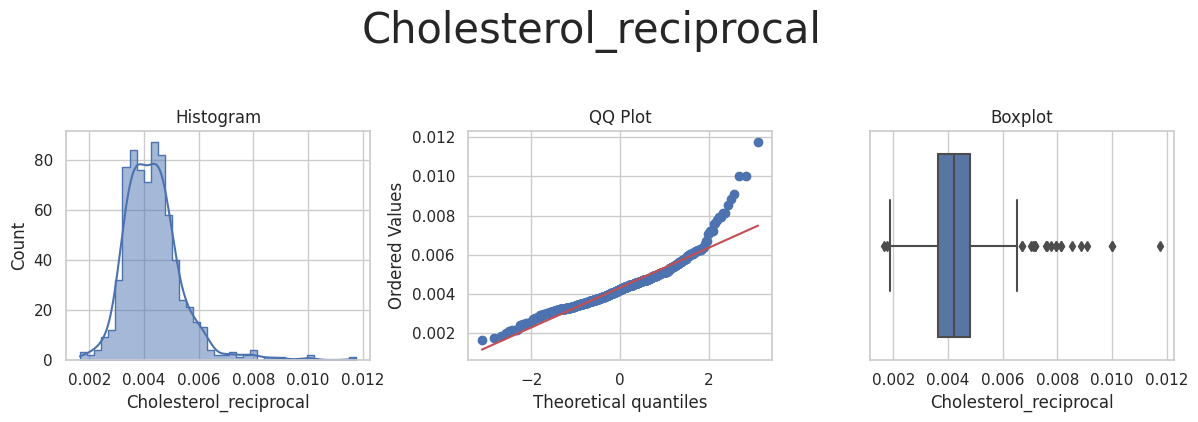

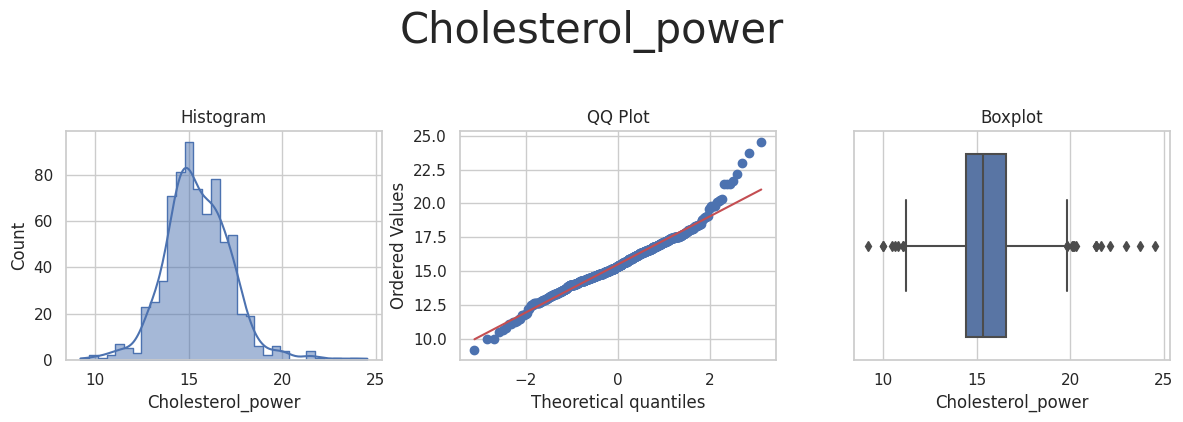

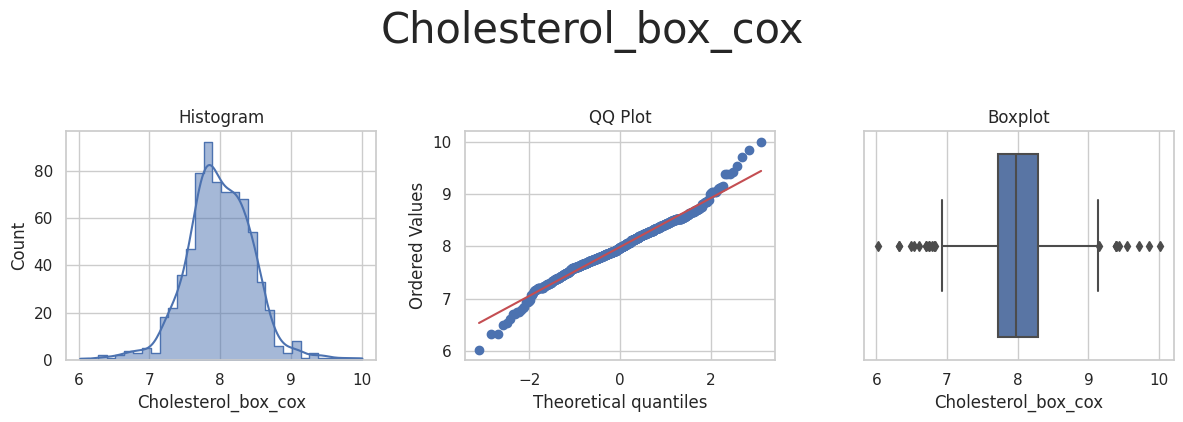

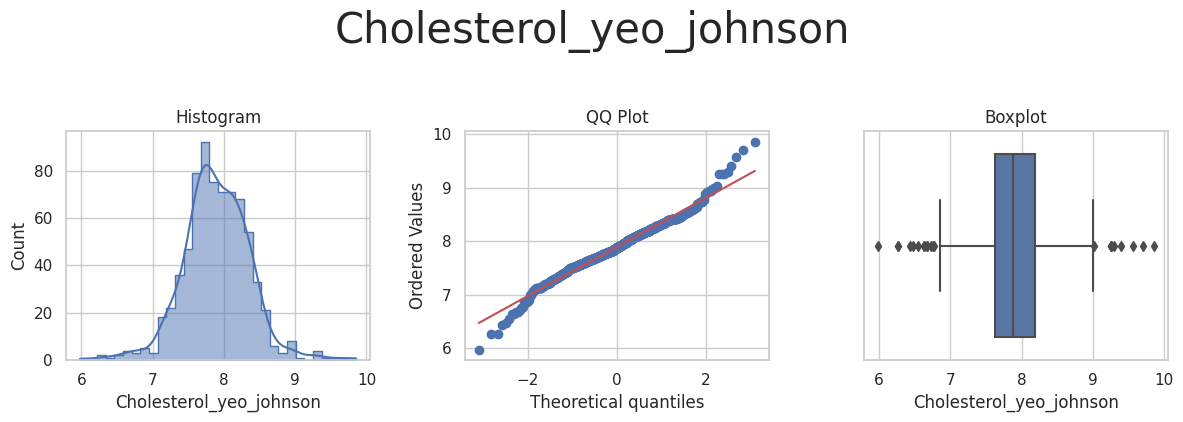



* Variable Analyzed: MaxHR
* Applied transformation: ['MaxHR_log_e', 'MaxHR_log_10', 'MaxHR_reciprocal', 'MaxHR_power', 'MaxHR_box_cox', 'MaxHR_yeo_johnson'] 



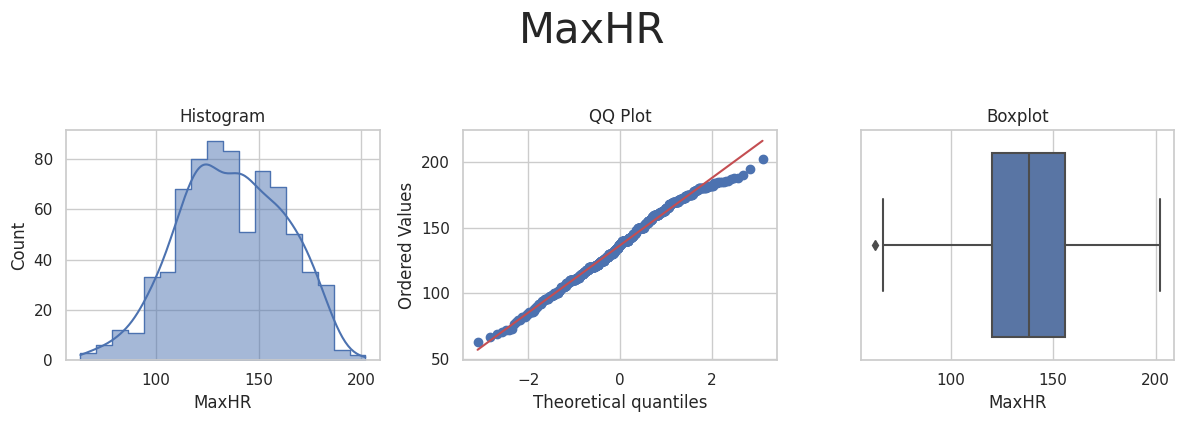

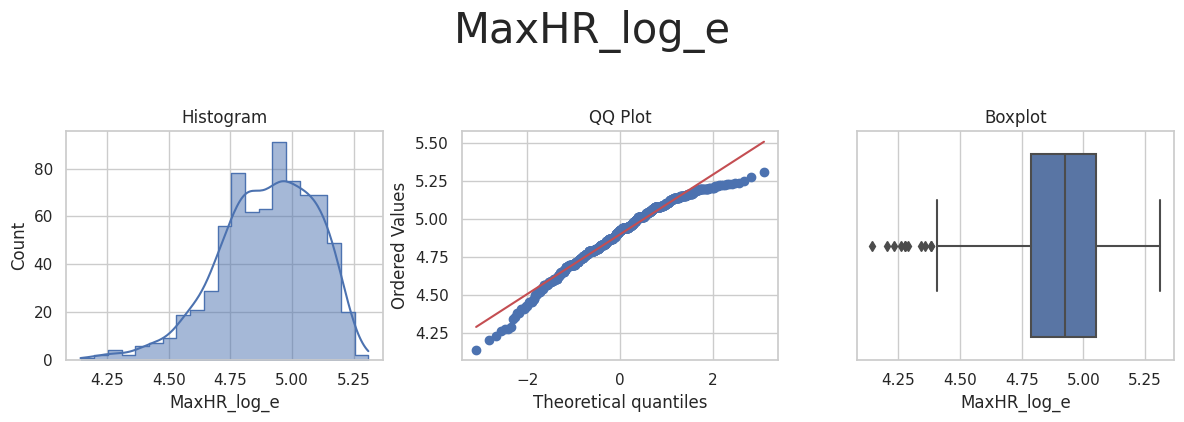

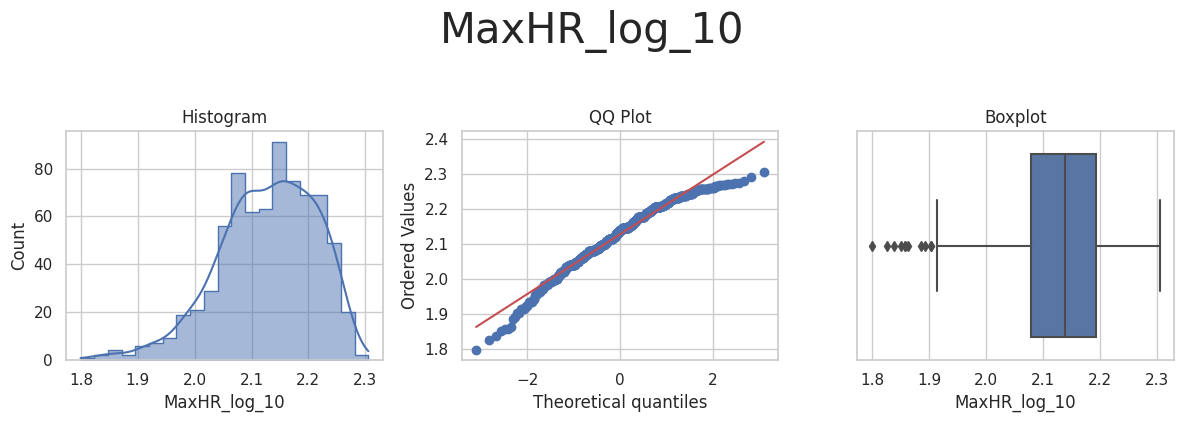

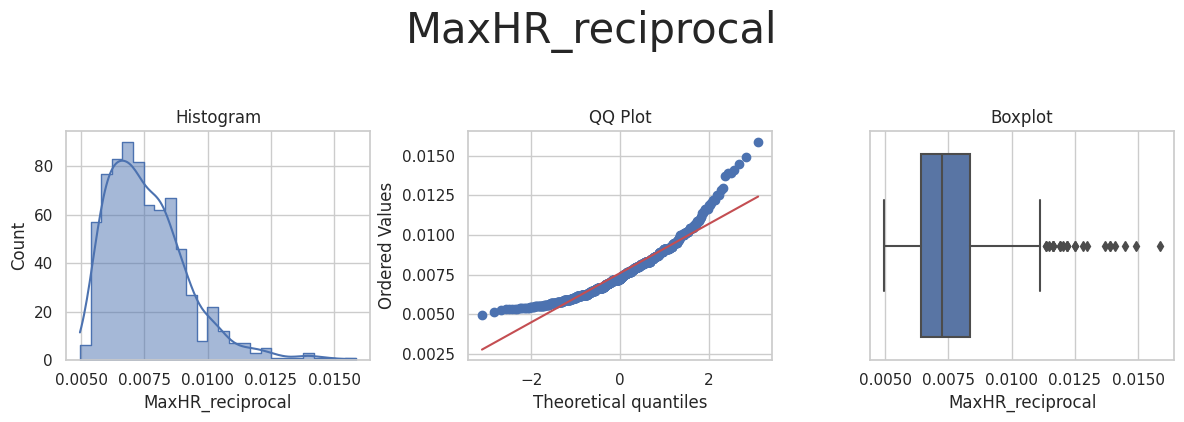

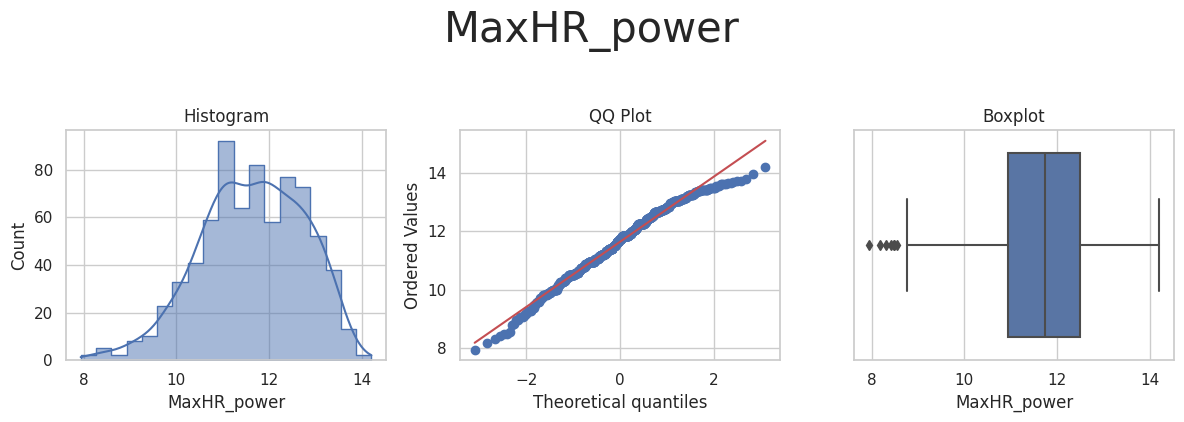

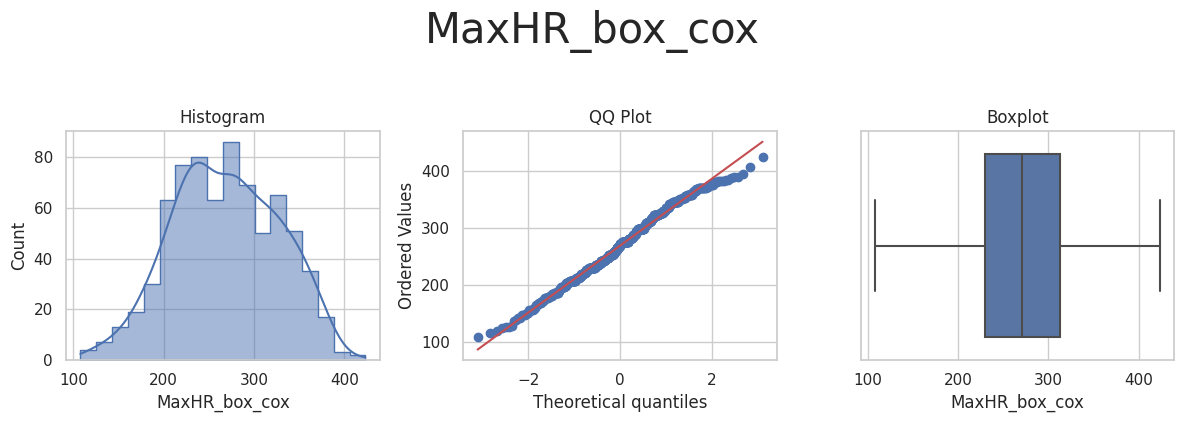

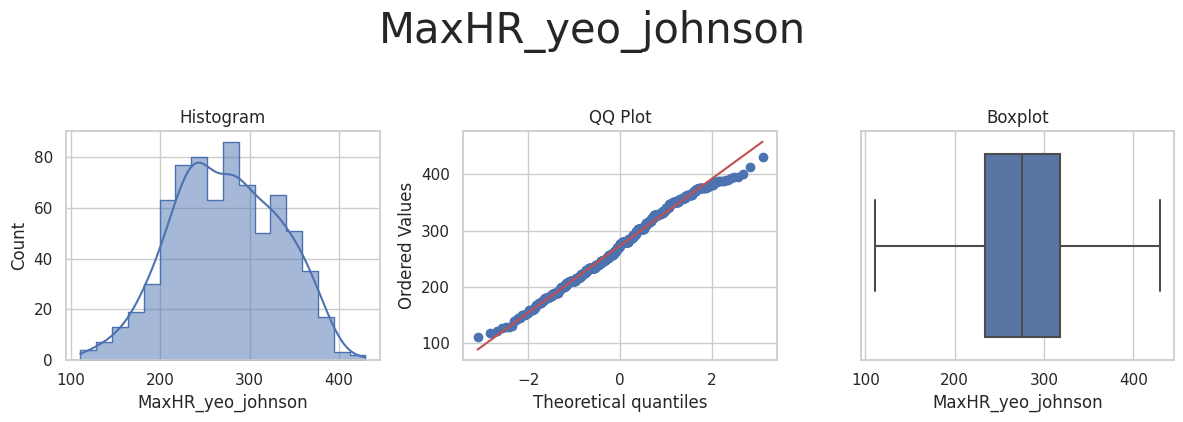



* Variable Analyzed: Oldpeak
* Applied transformation: ['Oldpeak_power', 'Oldpeak_yeo_johnson'] 



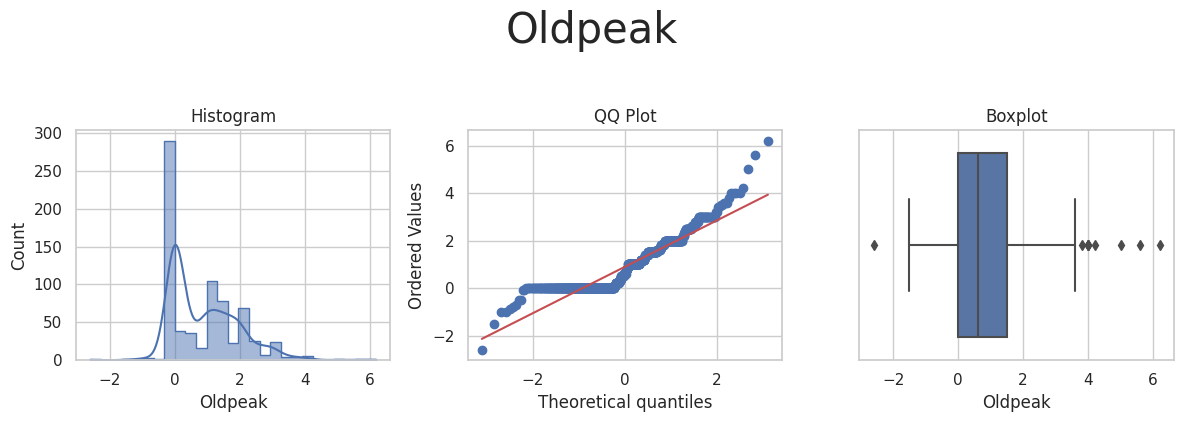

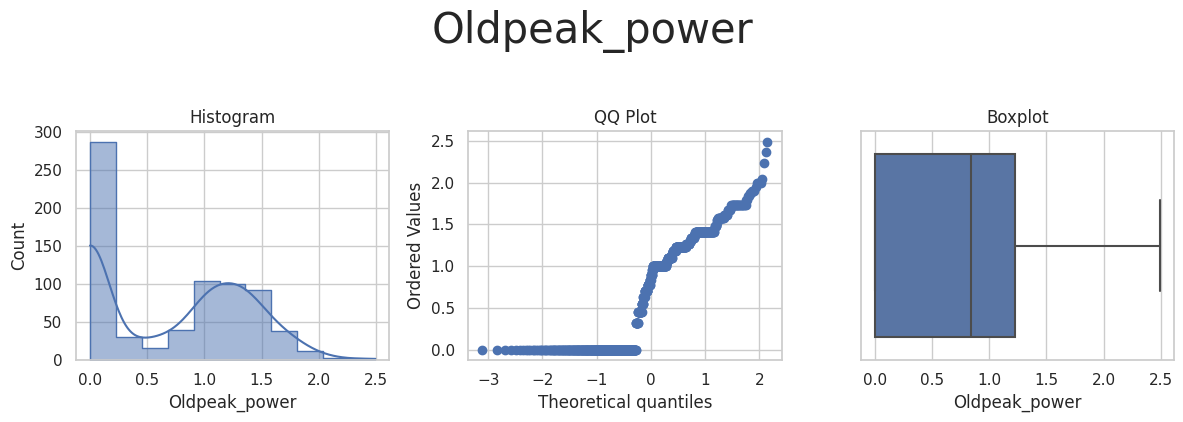

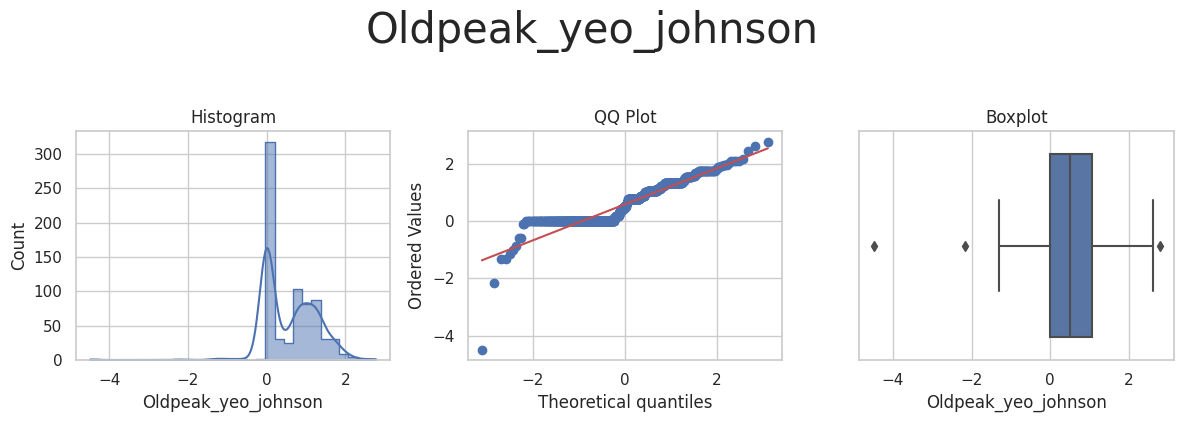

In [12]:
train_numerical = FeatureEngineeringAnalysis(df=train_numerical, analysis_type='numerical')

- The age and MaxHR feature do not need any numerical transformation as their distribution is already normalized
- Resting BP, Cholesterol and Oldpeak have outliars which require Winsorizer transformation
- The Oldpeak dsitribution appears to be bimodal


## Outliers

I am using the Winsorizer to handle outliers in the distributions of RestingBP, Cholesterol, and Oldpeak.

In [13]:
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
      ( 'winsorizer_iqr', Winsorizer(capping_method='iqr', fold=1.5, tail='both', variables=['Age', 'RestingBP','Cholesterol','Oldpeak']) )
])

df_transformed = pipeline.fit_transform(TrainSet)
df_transformed.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,70.0,0,0,140,335.0,1,0,157,0,2.0,0,1
1,46.0,0,0,115,186.0,0,0,113,0,1.5,0,1
2,65.0,1,1,160,360.0,0,1,151,1,0.8,1,0
3,66.0,0,0,140,139.0,0,0,94,0,1.0,0,1
4,59.0,0,0,140,274.0,0,2,117,0,1.0,0,1


Plotting the resulting distributions and boxplots

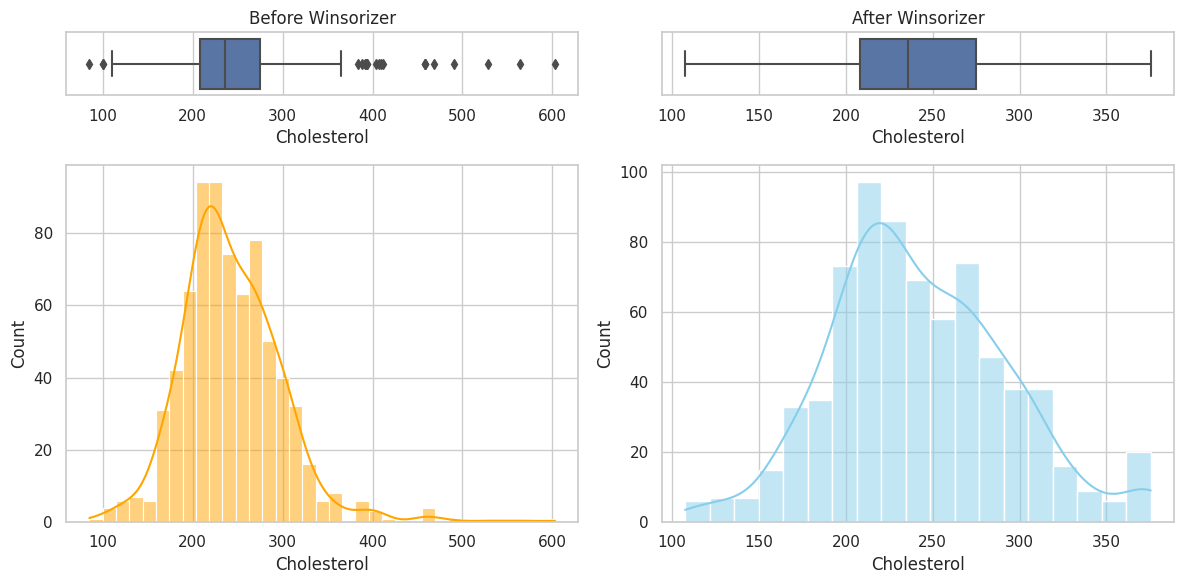

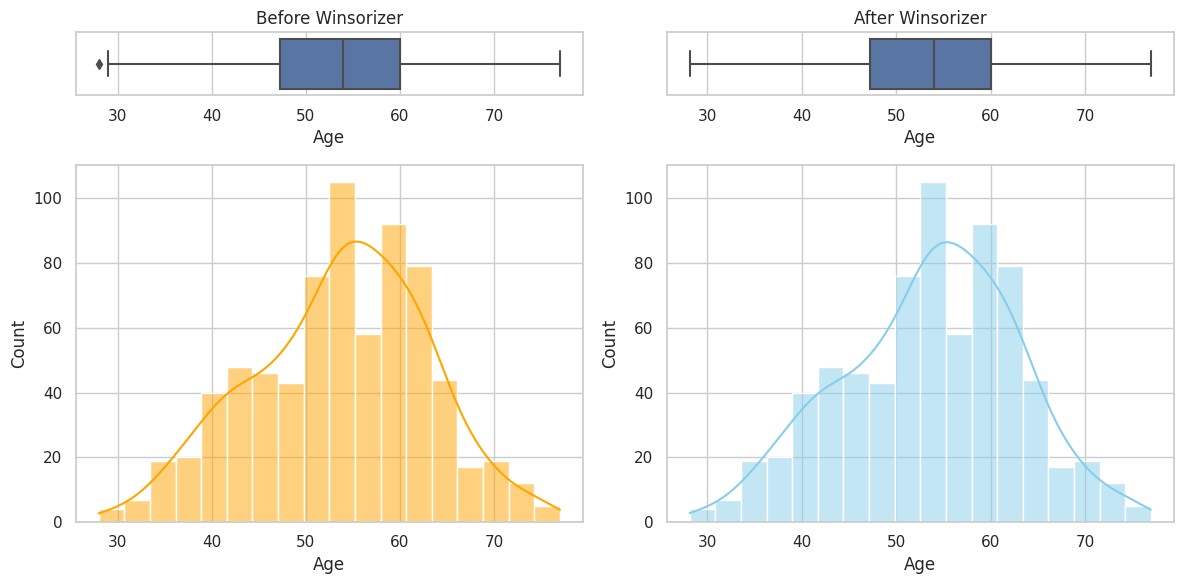

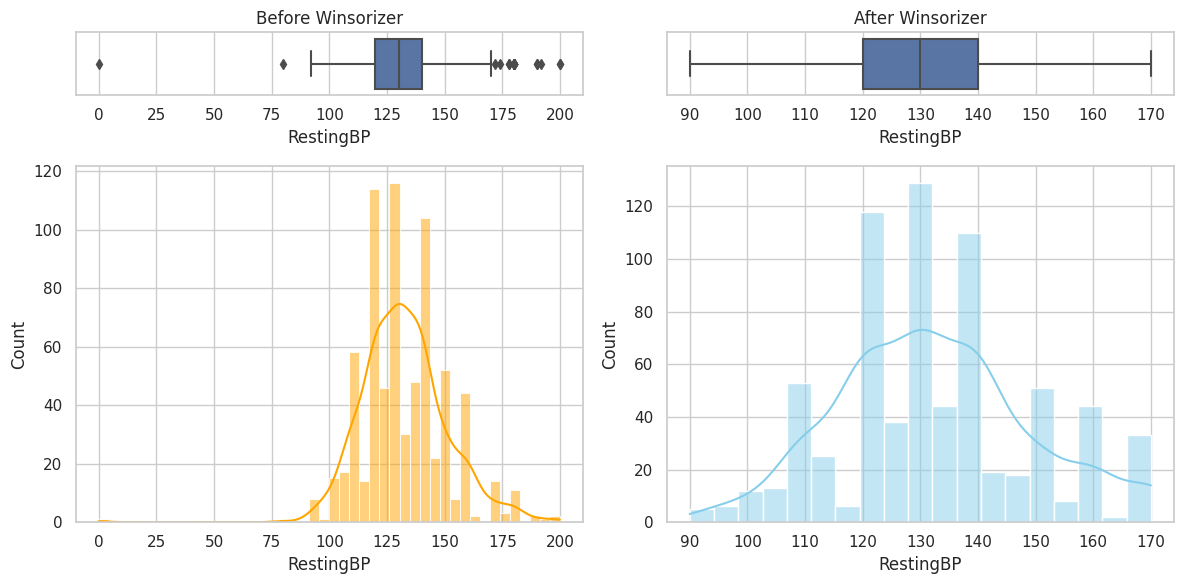

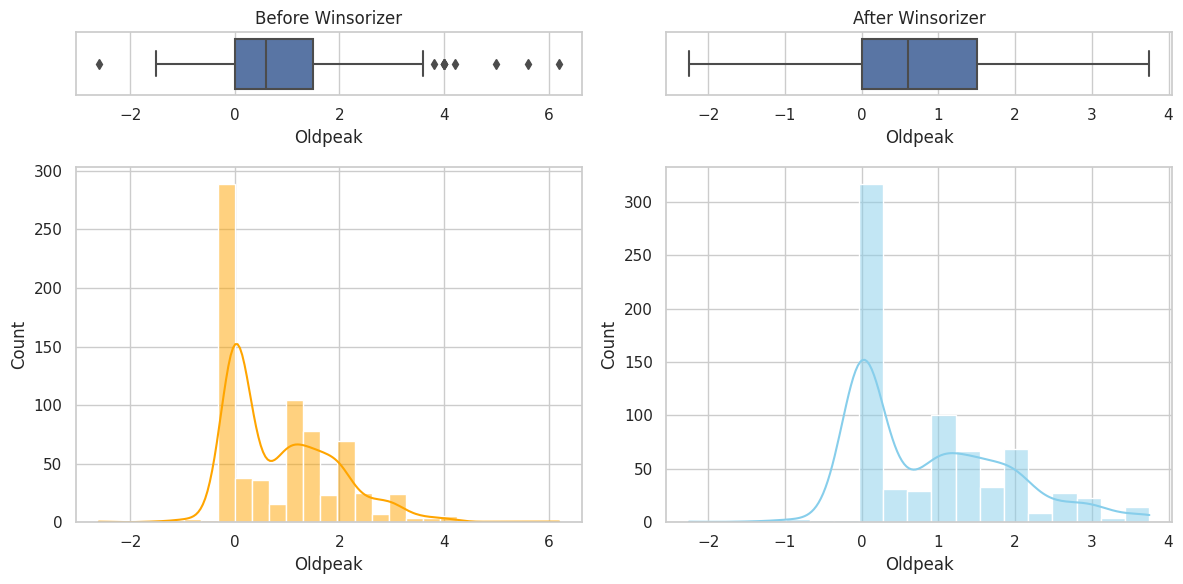

In [14]:
winsorized_feat = ['Cholesterol', 'Age', 'RestingBP', 'Oldpeak']

for col in winsorized_feat:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.boxplot(data=train_numerical, x=col, ax=axes[0, 0])
    sns.histplot(data=train_numerical, x=col, kde=True, ax=axes[1, 0], color='orange')
    axes[0, 0].set_title("Before Winsorizer")
    
    sns.boxplot(data=df_transformed, x=col, ax=axes[0, 1])
    sns.histplot(data=df_transformed, x=col, kde=True, ax=axes[1, 1], color='skyblue')
    axes[0, 1].set_title("After Winsorizer")
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

Apply the changes to the TrainSet dataframe

In [18]:
TrainSet = df_transformed.copy()


Applying the same changes to the Test dataframe

In [20]:
pipeline = Pipeline([
      ( 'winsorizer_iqr', Winsorizer(capping_method='iqr', fold=1.5, tail='both', variables=['Age', 'RestingBP','Cholesterol','Oldpeak']) )
])

TestSet = pipeline.fit_transform(TestSet)
TestSet.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,55,0,0,115,216.0,1,0,155,1,0.1,0,1
1,66,0,0,120,302.0,0,1,151,1,0.4,0,0
2,51,0,0,110,353.0,1,0,92,1,0.0,0,1
3,55,0,1,120,245.0,0,2,125,0,2.5,0,1
4,62,0,3,140,271.0,0,0,152,1,1.0,1,0


### SmartCorrelatedSelection Variables

Check which features correlate to each other

Create a copy of the train set

In [34]:
df_correlation = TrainSet.copy()
df_correlation.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,70.0,0,0,140,335.0,1,0,157,0,2.0,0,1
1,46.0,0,0,115,186.0,0,0,113,0,1.5,0,1
2,65.0,1,1,160,360.0,0,1,151,1,0.8,1,0


Check which are the features which correlates to each other according to the Spearman coefficient

In [35]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_correlation)
corr_sel.correlated_feature_sets_

[]

None of the feature shows a strict correlation

---

## Conclusion

I applied the following Feature Engineering Transformers:

- Ordinal categorical encoding: Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
- Winsorize: Cholesterol', 'Age', 'RestingBP', 'Oldpeak'